In [1]:
import numpy
import gwpy
%matplotlib inline
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.filter import matched_filter
from pycbc.filter import sigma

In [2]:
# Download the challenge set files
from pycbc.frame import read_frame
import urllib

def get_file(fname):
    url = "https://www.gw-openscience.org/s/workshop3/challenge/{}"
    url = url.format(fname)
    urllib.request.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['challenge1.gwf', 'challenge2.gwf'] #Manca challenge3.gwf

for fname in files:
    get_file(fname)
    

# An example of how to read the data from these files:
file_name = "challenge2.gwf"

# LOSC bulk data typically uses the same convention for internal channels names
# Strain is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1.
channel_name = "H1:CHALLENGE2"

strain = read_frame(file_name, channel_name)

Getting : https://www.gw-openscience.org/s/workshop3/challenge/challenge1.gwf
Getting : https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf


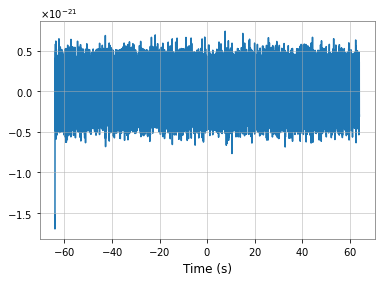

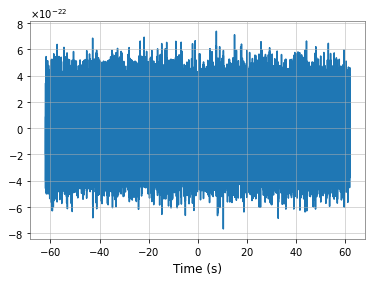

In [3]:
# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [4]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)

psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=15)

In [8]:
from pycbc.waveform import get_td_waveform
m = 30 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m, spin=0,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))

Text(0, 0.5, 'Strain')

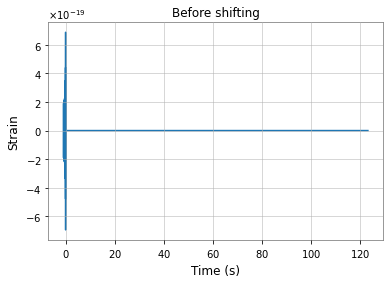

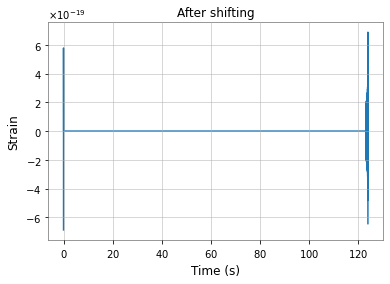

In [9]:
# Let's plot the signal before and after shifting
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

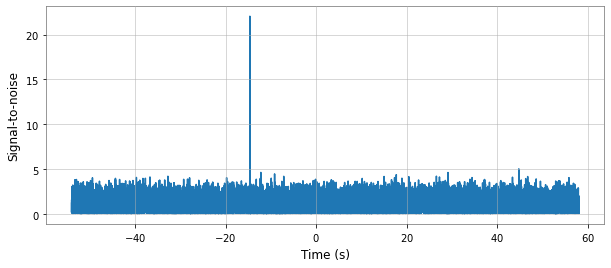

We found a signal at -14.6328125s with SNR 22.053006342518433


In [10]:
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))